In [1]:
#all import

import matplotlib.pyplot as plt
import numpy as np
import awkward as ak
import statsmodels.api as sm 

from coffea.nanoevents import NanoEventsFactory
from coffea.nanoevents import NanoAODSchema
from coffea import processor, hist
from statsmodels.stats.proportion import proportion_confint 
NanoAODSchema.warn_missing_crossrefs = True # no strict cross-references gives warning !

from raw_samples import raw_signal_samples
from helpers import files_from_dir
from tqdm import tqdm
import json
import pandas as pd

In [2]:
# custom HNLnanoAODschema class: for now, our custom NanoAOD do not have a strict cross-references convention as standard NanoAOD, so we make an exception for our custom Branches (in 'excluded_list')

import warnings
from coffea.nanoevents import transforms
from coffea.nanoevents.util import quote, concat
from coffea.nanoevents.schemas.base import BaseSchema, listarray_form, zip_forms, nest_jagged_forms


from coffea.nanoevents import transforms
from coffea.nanoevents.schemas import NanoAODSchema
class HNLnanoAODschema(NanoAODSchema):
    def _build_collections(self, branch_forms):
        # parse into high-level records (collections, list collections, and singletons)
        collections = set(k.split("_")[0] for k in branch_forms)
        collections -= set(
            k for k in collections if k.startswith("n") and k[1:] in collections
        )

        # Create offsets virtual arrays
        for name in collections:
            if "n" + name in branch_forms:
                branch_forms["o" + name] = transforms.counts2offsets_form(
                    branch_forms["n" + name]
                )

        # Create global index virtual arrays for indirection
        excluded_list= {'PatDSAMuon_l1Idx','PatDSAMuon_l2Idx','DiMuon_l1Idx','DiMuon_l2Idx','DiDSAMuon_l1Idx','DiDSAMuon_l2Idx'}
        idxbranches = [k for k in branch_forms if "Idx" in k and k not in excluded_list]
        for name in collections:
            indexers = [k for k in idxbranches if k.startswith(name + "_")]
            for k in indexers:
                target = k[len(name) + 1 : k.find("Idx")]
                target = target[0].upper() + target[1:]
                if target not in collections:
                    problem = RuntimeError(
                        "Parsing indexer %s, expected to find collection %s but did not"
                        % (k, target)
                    )
                    if self.__class__.warn_missing_crossrefs:
                        warnings.warn(str(problem), RuntimeWarning)
                        continue
                    else:
                        raise problem
                branch_forms[k + "G"] = transforms.local2global_form(
                    branch_forms[k], branch_forms["o" + target]
                )

        # Create nested indexer from Idx1, Idx2, ... arrays
        for name, indexers in self.nested_items.items():
            if all(idx in branch_forms for idx in indexers):
                branch_forms[name] = transforms.nestedindex_form(
                    [branch_forms[idx] for idx in indexers]
                )

        # Create any special arrays
        for name, (fcn, args) in self.special_items.items():
            if all(k in branch_forms for k in args):
                branch_forms[name] = fcn(*(branch_forms[k] for k in args))

        output = {}
        for name in collections:
            mixin = self.mixins.get(name, "NanoCollection")
            if "o" + name in branch_forms and name not in branch_forms:
                # list collection
                offsets = branch_forms["o" + name]
                content = {
                    k[len(name) + 1 :]: branch_forms[k]
                    for k in branch_forms
                    if k.startswith(name + "_")
                }
                output[name] = zip_forms(
                    content, name, record_name=mixin, offsets=offsets
                )
                output[name]["content"]["parameters"].update(
                    {
                        "__doc__": offsets["parameters"]["__doc__"],
                        "collection_name": name,
                    }
                )
            elif "o" + name in branch_forms:
                # list singleton, can use branch's own offsets
                output[name] = branch_forms[name]
                output[name]["parameters"].update(
                    {"__array__": mixin, "collection_name": name}
                )
            elif name in branch_forms:
                # singleton
                output[name] = branch_forms[name]
            else:
                # simple collection
                output[name] = zip_forms(
                    {
                        k[len(name) + 1 :]: branch_forms[k]
                        for k in branch_forms
                        if k.startswith(name + "_")
                    },
                    name,
                    record_name=mixin,
                )
                output[name]["parameters"].update({"collection_name": name})

        return output

In [3]:
# functions

def load_triggers(trig_types ,path):
    triggers = {}
    for trig_type in trig_types:
        with open(path +'triggers_{}_2018.json'.format(trig_type), 'r') as f:
            trig_list = json.load(f)
            for trig_desc in trig_list:
                if trig_desc['dataset'] in [ 'NotFound', 'HcalNZS' ]: continue  # We don't care of HLT with dataset NotFound or HcalNZS ???
                name = trig_desc['path']
                if name in [ 'HLT_Random_v', 'HLT_Physics_v']: continue # We don't care of HLT of the form HLT_Random/HLT_Physics
                if name.endswith('_v'):
                    name = name[:-2]
                if name in triggers:
                    raise RuntimeError('Duplicated trigger path = "{}"'.format(name))
                name = name.replace('HLT_', '')
                trig_desc['trig_type'] = trig_type
                triggers[name] = trig_desc
    return triggers

def finding_optimal_HLT(events, mask_events_selected, hlt_columns, eps, n_tot, lumi_ratio):
    Delta_eff = 1
    index_HLT_candidates = np.arange(len(hlt_columns))
    mask_HLT_already_selected = ak.zeros_like(np.zeros(len(events.GenPart),dtype=bool))
    saved_eff = []
    index_HLT_selected = []
    saved_err_eff = []

    iteration=0
    while Delta_eff > eps:
        mask_acc = []
        efficiency = []
        for index_HLT_candidate in index_HLT_candidates:
            mask_cut_HLT = events.HLT[hlt_columns[index_HLT_candidate]]
            mask_acc.append(mask_cut_HLT & np.invert(mask_HLT_already_selected) & mask_events_selected)
            efficiency.append(lumi_ratio[index_HLT_candidate]*np.sum(mask_acc[-1])/n_tot)

        index_max_eff = np.argmax(efficiency)
        index_HLT_selected.append(index_HLT_candidates[index_max_eff])
        mask_HLT_already_selected = mask_HLT_already_selected | mask_acc[index_max_eff]
        #saved_eff.append(efficiency[index_max_eff])
        saved_eff.append(np.sum(mask_HLT_already_selected)/n_tot)
        saved_err_eff.append(np.array(proportion_confint(count=np.sum(mask_HLT_already_selected), nobs=n_tot, alpha=(1-0.68), method='beta')))

        print('Events selected for HLT: ' + hlt_columns[index_HLT_selected[-1]])
        print(str(np.sum(mask_HLT_already_selected)))
        
        index_HLT_candidates = np.delete(index_HLT_candidates, np.where(index_HLT_candidates == index_HLT_selected[-1]))
        if iteration>1:
            Delta_eff = np.abs(saved_eff[-1]-saved_eff[-2])
        iteration = iteration + 1

    return index_HLT_selected, saved_eff, saved_err_eff

def lepton_mask_gen(events):
    #total number of events
    n_events_tot = len(events.GenPart)
    # split by channels (Gen level)
    #Select l1, l2 and l3 
    # --> is a lepton (last copy and from hard process)
    is_lepton = events.GenPart[((np.abs(events.GenPart.pdgId) == 11) | (np.abs(events.GenPart.pdgId) == 13) | (np.abs(events.GenPart.pdgId) == 15)) & events.GenPart.hasFlags(['isLastCopy']) & events.GenPart.hasFlags(['fromHardProcess'])]
    # --> # l1 l2 and l3 comes either from W+/W- or Z or HNL
    is_l1_l2_l3 = is_lepton[((np.abs(is_lepton.distinctParent.pdgId) == 24) | (np.abs(is_lepton.distinctParent.pdgId) == 23) | (np.abs(is_lepton.distinctParent.pdgId) == 9900012) | (np.abs(is_lepton.distinctParent.pdgId) < 9) | (np.abs(is_lepton.distinctParent.pdgId) == 21))]

    #sanity check: exactly 3 leptons selected for l1 l2 and l3
    if (ak.sum(ak.flatten(is_l1_l2_l3.pdgId < 20))/3 != n_events_tot):
        raise ValueError('Not exactly 3 lepton selected for l1 l2 and l3 !!!!')

    #useful mask
    e_mask = (abs(is_l1_l2_l3.pdgId) == 11)
    mu_mask = (abs(is_l1_l2_l3.pdgId) == 13)
    t_mask = (abs(is_l1_l2_l3.pdgId) == 15)
    t_e_mask = ak.any((abs(is_l1_l2_l3.distinctChildren.pdgId) == 11), axis=2) & t_mask
    t_mu_mask = ak.any((abs(is_l1_l2_l3.distinctChildren.pdgId) == 13), axis=2) & t_mask
    t_h_mask = np.invert(t_e_mask | t_mu_mask) & t_mask
    return t_mask, mu_mask, e_mask, t_e_mask, t_mu_mask, t_h_mask

def reco_mask_cut(events, cut_tau_pt,cut_tau_eta,cut_tau_id,cut_e_pt,cut_e_eta,cut_e_id,cut_mu_pt,cut_mu_eta,cut_mu_id,cut_mu_iso):
    #lepton selection (Reco level)
    tau_selected = events.Tau[(events.Tau.pt > cut_tau_pt) & (np.abs(events.Tau.eta) < cut_tau_eta) & (events.Tau.idDeepTau2017v2p1VSmu >= cut_tau_id) & (events.Tau.idDeepTau2017v2p1VSjet >= cut_tau_id) & (events.Tau.idDeepTau2017v2p1VSe >= cut_tau_id)]
    electron_selected = events.Electron[(events.Electron.pt > cut_e_pt) & (np.abs(events.Electron.eta) < cut_e_eta) & ((events.Electron.mvaFall17V2Iso_WP90 > cut_e_id) | (events.Electron.mvaFall17V2noIso_WP90 > cut_e_id))]
    muon_selected = events.Muon[(events.Muon.pt > cut_mu_pt) & (np.abs(events.Muon.eta) < cut_mu_eta) & ((events.Muon.mediumId > cut_mu_id) | (events.Muon.tightId > cut_mu_id)) & (events.Muon.pfRelIso03_all < cut_mu_iso)]

    # require at least 1 reco tau and 3 reco leptons (e/mu/tau)
    number_of_lepton = ak.num(tau_selected) + ak.num(electron_selected) + ak.num(muon_selected)
    mask_selection = (number_of_lepton >= 3) & (ak.num(tau_selected) >= 1)
    return mask_selection

def plot_cumulative_eff_opt_HLT(path_fig, HNLsamples, mode, hlt_columns, index_HLT_selected, saved_eff, saved_err_eff):
    x = np.arange(len(index_HLT_selected))
    my_xticks_labels = []
    for j in x:
        my_xticks_labels.append(hlt_columns[index_HLT_selected[j]])

    fig, ax = plt.subplots(1,1) 
    ax.errorbar(x,saved_eff, yerr= abs(np.array(saved_err_eff).T - saved_eff), fmt='o-',ecolor = 'black', capsize=5)
    ax.set_ylabel(r'$n_{pass}/n_{tot}$')
    ax.set_xticks(x)
    ax.set_xticklabels(my_xticks_labels, rotation=45, ha='right')
    ax.grid(axis='x', color='black', linestyle=(0, (1, 10)), linewidth=0.5)
    plt.savefig(path_fig+'cumulative_eff_opt_HLT/'+mode+'/HLT_eff_' + HNLsamples + '_'+ mode +'.pdf', bbox_inches='tight')

    return

def plot_cumulative_eff_mass(path_fig, most_common_HLT, color, eff_HLT, err_eff_HLT, mode, eff_computation):
    mass = [85,100,125,150,200,250,300,350,400,450,500,600,700,800,900,1000]
    adding_data = np.zeros(len(mass))
    fig, ax = plt.subplots(1,1)
    for i in range(len(most_common_HLT)-1):
        ax.bar(np.array(mass),[eff[i] for eff in eff_HLT], width=15,label= most_common_HLT[i], color = color[i], bottom = adding_data)
        #ax.errorbar(np.array(x),[eff[i] for eff in eff_HLT],yerr=np.array([err[i] for err in err_eff_HLT]).T,label= most_common_HLT[i], color = color[i],marker=',',linewidth=0.5)
        adding_data = adding_data + np.array([eff[i] for eff in eff_HLT])
    ax.bar(np.array(mass),[eff[i+1] for eff in eff_HLT],yerr= np.array([err[i+1] for err in err_eff_HLT]).T - np.array(adding_data), capsize=2., width=15,label= most_common_HLT[i+1], color = color[i+1], bottom = adding_data)

    ax.set_ylabel('efficiency')
    ax.set_xlabel('HNL Mass [GeV]')
    ax.legend(prop={'size': 6})
    plt.savefig(path_fig+'cumulative_eff_mass/Trigger_cumu_eff_'+ mode +'_'+ eff_computation +'.pdf', bbox_inches='tight')
    return

def plot_raw_eff_mass(path_fig, most_common_HLT, color, eff_HLT, err_eff_HLT, mode, eff_computation):
    mass = [85,100,125,150,200,250,300,350,400,450,500,600,700,800,900,1000]
    delta= [[-6,-3,0,3,6],[-10,-5,0,5,10],[-14,-7,0,7,14]]
    wi= [3,5,7]
    fig, ax = plt.subplots(1,1)
    for i in range(len(most_common_HLT)):
        ax.bar((np.array(mass[0:2])+delta[0][i]),([eff[i] for eff in eff_HLT[0:2]]),yerr= (abs(np.array([err[i] for err in err_eff_HLT[0:2]]).T-np.array([eff[i] for eff in eff_HLT[0:2]]))),error_kw=dict(elinewidth=0.5), width=wi[0],label= most_common_HLT[i], color = color[i])
    ax.legend(prop={'size': 6})

    for i in range(len(most_common_HLT)):
        ax.bar((np.array(mass[2:4])+delta[1][i]),([eff[i] for eff in eff_HLT[2:4]]),yerr= (abs(np.array([err[i] for err in err_eff_HLT[2:4]]).T-np.array([eff[i] for eff in eff_HLT[2:4]]))),error_kw=dict(elinewidth=0.5), width=wi[1],label= most_common_HLT[i], color = color[i])
        ax.bar((np.array(mass[4:])+delta[2][i]),([eff[i] for eff in eff_HLT[4:]]),yerr= (abs(np.array([err[i] for err in err_eff_HLT[4:]]).T-np.array([eff[i] for eff in eff_HLT[4:]]))),error_kw=dict(elinewidth=0.5), width=wi[2],label= most_common_HLT[i], color = color[i])
    ax.set_ylabel('raw efficiency')
    ax.set_xlabel('HNL Mass [GeV]')
    plt.savefig(path_fig+'cumulative_eff_mass/Trigger_raw_eff_'+ mode +'_'+ eff_computation +'.pdf', bbox_inches='tight')
    return

def cumu_eff(events, most_common_HLT, triggers, max_act_lumi, mask_events_selected, n_events):
    mask_HLT_already_selected = ak.zeros_like(np.zeros(len(events.GenPart),dtype=bool))
    saved_eff = []
    saved_err_eff = []
    for i in np.arange(len(most_common_HLT)):
        mask_cut_HLT = events.HLT[most_common_HLT[i]]
        ratio_lum = triggers[most_common_HLT[i]]['eff_lumi']/max_act_lumi
        mask_acc = mask_cut_HLT & mask_events_selected & np.invert(mask_HLT_already_selected)
        saved_eff.append(ratio_lum*np.sum(mask_acc)/n_events)
        mask_HLT_already_selected = mask_HLT_already_selected | mask_acc
        saved_err_eff.append(np.array(proportion_confint(count=np.sum(mask_HLT_already_selected), nobs=n_events, alpha=(1-0.68), method='beta')))
    return saved_eff, saved_err_eff

def raw_eff(events, most_common_HLT, triggers, max_act_lumi, mask_events_selected, n_events):
    raw_saved_eff = []
    raw_saved_err_eff = []
    for i in np.arange(len(most_common_HLT)):
        mask_cut_HLT = events.HLT[most_common_HLT[i]]
        ratio_lum = triggers[most_common_HLT[i]]['eff_lumi']/max_act_lumi
        mask_acc = mask_cut_HLT & mask_events_selected
        raw_saved_eff.append(ratio_lum*np.sum(mask_acc)/n_events)
        raw_saved_err_eff.append(ratio_lum*np.array(proportion_confint(count=np.sum(mask_acc), nobs=n_events, alpha=(1-0.68), method='beta')))
    return raw_saved_eff, raw_saved_err_eff

In [4]:
#parameters
#directory where the HNL data are stored
local_dir = '/Users/debryas/cernbox/HNL/skimmed_samples/nanoAOD/2018/HNL_tau/'
#directory where the triggers lumi file are stored
path_trigger = '/Users/debryas/Desktop/PhD_work/HNL_tau_analysis/accept/'
#directory where the figures are stored
path_fig = '/Users/debryas/Desktop/PhD_work/HNL_tau_analysis/HLT_analysis/figures/'

# Reco event selection: require at least 1 reco tau and 3 reco leptons (e/mu/tau)
#cut to apply
#tau
cut_tau_pt = 20. # Tau_pt > cut_tau_pt
cut_tau_eta = 2.3 #abs(Tau_eta) < cut_tau_eta
cut_tau_id = 2 # Tau_idDeepTau2017v2p1VSmu >= cut_tau_id; Tau_idDeepTau2017v2p1VSjet >= cut_tau_id; Tau_idDeepTau2017v2p1VSe >= cut_tau_id
#electrons
cut_e_pt = 5. # Electron_pt > cut_e_pt
cut_e_eta = 2.5 # abs(Electron_eta) < cut_e_eta
cut_e_id = 0 # (Electron_mvaFall17V2Iso_WP90 > cut_e_id || Electron_mvaFall17V2noIso_WP90 > cut_e_id)
#muons
cut_mu_pt = 5. # Muon_pt > cut_mu_pt
cut_mu_eta = 2.4 # abs(Muon_eta) < cut_mu_eta
cut_mu_id = 0 #(Muon_mediumId > cut_mu_id || Muon_tightId > cut_mu_id)
cut_mu_iso = 0.5 # Muon_pfRelIso03_all < cut_mu_iso

mode = 'tte' #could be tte, ttm, tee, tmm, tem or all
trig_types = ['prompt']
eps = 0.01
eff_computation = 'channel_reco'

601 HLT appears in this list (json file)
----------------------------------------------------------------------
HLT analysis for HNL85 and channel tte
number of events: 434335
number of events after reco selection: 22829
number of events after gen selection (mode tte): 136966
number of events after reco and channel selection: 4232
651 HLT appear in the root data file
525 HLT to be analysed (common with HLT list)
Total luminosity: 59.97
Events selected for HLT: Ele32_WPTight_Gsf_L1DoubleEG
1758
Events selected for HLT: DoubleMediumChargedIsoPFTauHPS35_Trk1_eta2p1_Reg
1949
Events selected for HLT: Ele24_eta2p1_WPTight_Gsf_LooseChargedIsoPFTauHPS30_eta2p1_CrossL1
2101
Events selected for HLT: Ele23_Ele12_CaloIdL_TrackIdL_IsoVL
2171
Events selected for HLT: Ele28_WPTight_Gsf
2338
Events selected for HLT: Diphoton30_18_R9IdL_AND_HE_AND_IsoCaloId_NoPixelVeto
2383
Events selected for HLT: PFMET120_PFMHT120_IDTight_PFHT60
2413


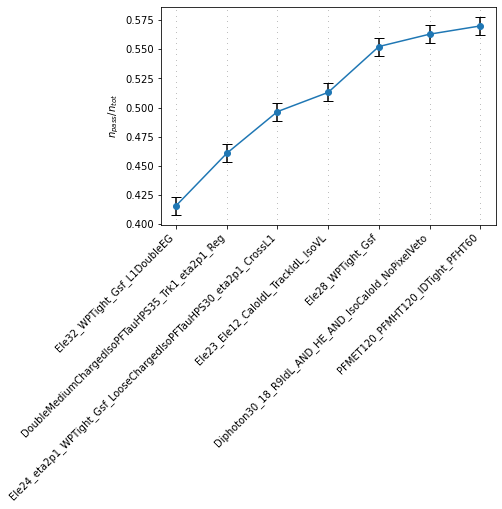

In [14]:
#save triggers in a variable
triggers = load_triggers(trig_types ,path_trigger)
print(str(len(triggers))+' HLT appears in this list (json file)')

HLT = {}
for HNLsamples in raw_signal_samples:

    print('----------------------------------------------------------------------')
    print('HLT analysis for '+ HNLsamples+' and channel '+ mode)

    #load events in the HNL file
    fname = local_dir+raw_signal_samples[HNLsamples]
    events = NanoEventsFactory.from_root(fname,schemaclass=HNLnanoAODschema).events()
    n_events_tot = len(events.GenPart)

    print('number of events: '+ str(n_events_tot))

    #mask at gen level
    t_mask, mu_mask, e_mask, t_e_mask, t_mu_mask, t_h_mask = lepton_mask_gen(events)

    #sanity check: exactly 3 leptons selected for the different mask
    if ((ak.sum(ak.flatten(e_mask))+ak.sum(ak.flatten(mu_mask)) + ak.sum(ak.flatten(t_e_mask)) + ak.sum(ak.flatten(t_mu_mask)) + ak.sum(ak.flatten(t_h_mask)))/n_events_tot) != 3:
        print('not exactly 3 candidate selected in the mask')

    #mask at reco level
    mask_reco = reco_mask_cut(events, cut_tau_pt,cut_tau_eta,cut_tau_id,cut_e_pt,cut_e_eta,cut_e_id,cut_mu_pt,cut_mu_eta,cut_mu_id,cut_mu_iso)

    print('number of events after reco selection: '+ str(ak.sum(mask_reco)))

    mode_list = ['ttt','tte','ttm','tee','tmm','tem']
    if mode not in mode_list:
        mode_mask = ak.ones_like(np.ones(n_events_tot,dtype=bool))
        print('Default mode: all event selected')
    else:
        if mode == 'ttt':
            mode_mask = (ak.sum(t_h_mask, axis =1) == 3)
            #print('Events in ' + mode + ': ' + str(ak.sum(mode_mask)/n_events_tot*100))
        if mode == 'tte':
            mode_mask = (ak.sum(t_h_mask, axis =1) == 2) & ( (ak.sum(t_e_mask, axis =1) == 1) | (ak.sum(e_mask, axis =1) == 1) )
            #print('Events in ' + mode + ': ' + str(ak.sum(mode_mask)/n_events_tot*100))
        if mode == 'ttm':
            mode_mask = (ak.sum(t_h_mask, axis =1) == 2) & ( (ak.sum(t_mu_mask, axis =1) == 1) | (ak.sum(mu_mask, axis =1) == 1) )
            #print('Events in ' + mode + ': ' + str(ak.sum(mode_mask)/n_events_tot*100))
        if mode == 'tee':
            mode_mask = (ak.sum(t_h_mask, axis =1) == 1) & ( ( (ak.sum(t_e_mask, axis =1) == 1) & (ak.sum(e_mask, axis =1) == 1) ) | (ak.sum(t_e_mask, axis =1) == 2) | (ak.sum(e_mask, axis =1) == 2) )
            #print('Events in ' + mode + ': ' + str(ak.sum(mode_mask)/n_events_tot*100))
        if mode == 'tmm':
            mode_mask = (ak.sum(t_h_mask, axis =1) == 1) & ( ( (ak.sum(t_mu_mask, axis =1) == 1) & (ak.sum(mu_mask, axis =1) == 1) ) | (ak.sum(t_mu_mask, axis =1) == 2) | (ak.sum(mu_mask, axis =1) == 2) )
            #print('Events in ' + mode + ': ' + str(ak.sum(mode_mask)/n_events_tot*100))
        if mode == 'tem':
            mode_mask = (ak.sum(t_h_mask, axis =1) == 1) & ( ( (ak.sum(e_mask, axis =1) == 1) & (ak.sum(mu_mask, axis =1) == 1) ) | ( (ak.sum(e_mask, axis =1) == 1) & (ak.sum(t_mu_mask, axis =1) == 1) ) | ( (ak.sum(t_e_mask, axis =1) == 1) & (ak.sum(mu_mask, axis =1) == 1) ) | ( (ak.sum(t_e_mask, axis =1) == 1) & (ak.sum(t_mu_mask, axis =1) == 1) ) )
            #print('Events in ' + mode + ': ' + str(ak.sum(mode_mask)/n_events_tot*100))

    print('number of events after gen selection (mode ' + mode + '): '+ str(ak.sum(mode_mask)))

    mask_events_selected = mask_reco & mode_mask
    print('number of events after reco and channel selection: '+ str(ak.sum(mask_events_selected)))

    #look the common hlt in the root file and in the json, and store it in hlt_columns
    columns = sorted([ str(c) for c in events['HLT'].fields ])
    hlt_columns = [c for c in columns if c in triggers]

    print(str(len(columns))+' HLT appear in the root data file')
    print(str(len(hlt_columns))+' HLT to be analysed (common with HLT list)')

    # Compute max luminosity
    max_act_lumi = max(triggers[hlt_columns[i]]['act_lumi'] for i in np.arange(len(hlt_columns)))
    print('Total luminosity: ' + str(max_act_lumi))

    # Compute luminosity ratio (to compute efficiency)
    lumi_ratio = []
    for i in np.arange(len(hlt_columns)):
        name = hlt_columns[i]
        lumi_ratio.append(triggers[name]['eff_lumi']/max_act_lumi)

    eff_computation_list = ['full', 'channel', 'reco', 'channel_reco']
    if eff_computation not in eff_computation_list:
        n_events = n_events_tot
        print('Default mode: all event selected for efficency computation')
    else:
        if eff_computation == 'full':
            n_events = n_events_tot
        if eff_computation == 'channel':
            n_events = ak.sum(mode_mask)
        if eff_computation == 'reco':
            n_events = ak.sum(mask_reco)
        if eff_computation == 'channel_reco':
            n_events = ak.sum(mask_events_selected)

    index_HLT_selected, saved_eff, saved_err_eff = finding_optimal_HLT(events, mask_events_selected, hlt_columns, eps, n_events)

    plot_cumulative_eff_opt_HLT(path_fig, hlt_columns, index_HLT_selected, saved_eff, saved_err_eff)

    #save HLT for each mass
    HLT_selected = []
    for i in range(len(index_HLT_selected)):
        HLT_selected.append(hlt_columns[index_HLT_selected[i]])

    HLT[HNLsamples] = HLT_selected

#save 
with open('optimal_HLT_'+mode+'.json', 'w') as fp:
    json.dump(HLT, fp)


In [12]:
mode = 'tee'
not_wanted_HLT = ['Diphoton30_18_R9IdL_AND_HE_AND_IsoCaloId_NoPixelVeto','IsoTrackHB','MediumChargedIsoPFTau50_Trk30_eta2p1_1pr_MET100']

with open('optimal_HLT_'+mode+'.json', 'r') as fp:
    HLT = json.load(fp)

most_common_HLT_list = []
score = []
len_HLT = []
i=0
for HNLsamples in raw_signal_samples:
    most_common_HLT_list.append(HLT[HNLsamples])
    for bad_HLT in not_wanted_HLT:
        try:
            while True:
                most_common_HLT_list[-1].remove(bad_HLT)
        except ValueError:
            pass
    len_HLT.append(len(most_common_HLT_list[-1]))
    score.append(1+np.array(range(len(most_common_HLT_list[-1]))))


list = np.concatenate(most_common_HLT_list).tolist()
HLT_found = pd.value_counts(np.array(list)).index.values

score_list = []
for HLT in HLT_found:
    #print(HLT)
    HLT_score = 0
    for i in range(len(raw_signal_samples)):
        if any(score[i][np.array(most_common_HLT_list[i]) == HLT]):
            HLT_score= HLT_score + np.sum(score[i][np.array(most_common_HLT_list[i]) == HLT])
        else:
            HLT_score= HLT_score + max(len_HLT)
    #print(HLT_score)
    score_list.append(HLT_score)

ordered_list = []
i=0
while (i < len(score_list)):
    found_index = np.where(np.partition(score_list, i)[i] == score_list)[0]
    for j in range(len(found_index)):
        index = found_index[j]
        ordered_list.append(HLT_found[index])
    i = i + j + 1
print('5 most common HLT for mode ' + mode)
print(ordered_list[0:5])

most common HLT for mode tee
['Ele32_WPTight_Gsf_L1DoubleEG', 'Ele23_Ele12_CaloIdL_TrackIdL_IsoVL', 'DoubleMediumChargedIsoPFTauHPS35_Trk1_eta2p1_Reg', 'PFMET120_PFMHT120_IDTight_PFHT60', 'Ele32_WPTight_Gsf']


In [15]:
with open('optimal_HLT_'+mode+'.json', 'r') as fp:
    HLT = json.load(fp)
print(HLT)
['Ele32_WPTight_Gsf_L1DoubleEG', 'Ele23_Ele12_CaloIdL_TrackIdL_IsoVL', 'DoubleMediumChargedIsoPFTauHPS35_Trk1_eta2p1_Reg', 'PFMET120_PFMHT120_IDTight_PFHT60', 'Ele32_WPTight_Gsf']
#select the most common HLT
most_common_HLT_ttt = []
most_common_HLT_tte = ['Ele32_WPTight_Gsf_L1DoubleEG', 'DoubleMediumChargedIsoPFTauHPS35_Trk1_eta2p1_Reg', 'Ele24_eta2p1_WPTight_Gsf_LooseChargedIsoPFTauHPS30_eta2p1_CrossL1', 'PFMET120_PFMHT120_IDTight_PFHT60','PFMETNoMu120_PFMHTNoMu120_IDTight_PFHT60']
most_common_HLT_ttm = ['IsoMu24', 'DoubleMediumChargedIsoPFTauHPS35_Trk1_eta2p1_Reg', 'PFMETNoMu120_PFMHTNoMu120_IDTight_PFHT60', 'IsoMu20_eta2p1_LooseChargedIsoPFTauHPS27_eta2p1_CrossL1','Mu17_Photon30_IsoCaloId']
most_common_HLT_tee = ['Ele32_WPTight_Gsf_L1DoubleEG', 'Ele32_WPTight_Gsf', 'Ele23_Ele12_CaloIdL_TrackIdL_IsoVL', 'PFMET120_PFMHT120_IDTight_PFHT60','DoubleMediumChargedIsoPFTauHPS35_Trk1_eta2p1_Reg']
most_common_HLT_tmm = ['IsoMu24', 'Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ_Mass3p8', 'PFMETNoMu120_PFMHTNoMu120_IDTight_PFHT60', 'IsoMu20_eta2p1_LooseChargedIsoPFTauHPS27_eta2p1_CrossL1','DoubleMu3_DCA_PFMET50_PFMHT60']
most_common_HLT_tem = ['IsoMu24', 'Ele32_WPTight_Gsf_L1DoubleEG', 'Mu8_TrkIsoVVL_Ele23_CaloIdL_TrackIdL_IsoVL_DZ', 'PFMETNoMu120_PFMHTNoMu120_IDTight_PFHT60','IsoMu20_eta2p1_LooseChargedIsoPFTauHPS27_eta2p1_CrossL1']
#select color for plotting
color = ['cornflowerblue','indianred','sandybrown','darkseagreen','magenta']

{'HNL85': ['Ele32_WPTight_Gsf_L1DoubleEG', 'DoubleMediumChargedIsoPFTauHPS35_Trk1_eta2p1_Reg', 'Ele24_eta2p1_WPTight_Gsf_LooseChargedIsoPFTauHPS30_eta2p1_CrossL1', 'Ele23_Ele12_CaloIdL_TrackIdL_IsoVL', 'Ele28_WPTight_Gsf', 'Diphoton30_18_R9IdL_AND_HE_AND_IsoCaloId_NoPixelVeto', 'PFMET120_PFMHT120_IDTight_PFHT60']}


----------------------------------------------------------------------
HLT analysis for HNL85 and channel tte
number of events after reco and channel selection: 4232
----------------------------------------------------------------------
HLT analysis for HNL100 and channel tte
number of events after reco and channel selection: 5455
----------------------------------------------------------------------
HLT analysis for HNL125 and channel tte
number of events after reco and channel selection: 11055
----------------------------------------------------------------------
HLT analysis for HNL150 and channel tte
number of events after reco and channel selection: 14903
----------------------------------------------------------------------
HLT analysis for HNL200 and channel tte
number of events after reco and channel selection: 5913
----------------------------------------------------------------------
HLT analysis for HNL250 and channel tte
number of events after reco and channel selection: 75

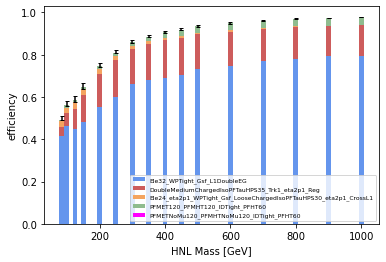

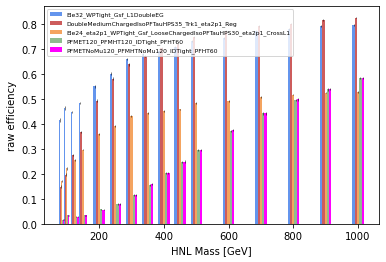

In [123]:
eff_HLT = []
err_eff_HLT = []

raw_eff_HLT = []
raw_err_eff_HLT = []
for HNLsamples in raw_signal_samples:
    print('----------------------------------------------------------------------')
    print('HLT analysis for '+ HNLsamples+' and channel '+ mode)

    #load events in the HNL file
    fname = local_dir+raw_signal_samples[HNLsamples]
    events = NanoEventsFactory.from_root(fname,schemaclass=HNLnanoAODschema).events()
    n_events_tot = len(events.GenPart)

    #mask at gen level
    t_mask, mu_mask, e_mask, t_e_mask, t_mu_mask, t_h_mask = lepton_mask_gen(events)

    #sanity check: exactly 3 leptons selected for the different mask
    if ((ak.sum(ak.flatten(e_mask))+ak.sum(ak.flatten(mu_mask)) + ak.sum(ak.flatten(t_e_mask)) + ak.sum(ak.flatten(t_mu_mask)) + ak.sum(ak.flatten(t_h_mask)))/n_events_tot) != 3:
        print('Not exactly 3 candidate selected in the mask')

    #mask at reco level
    mask_reco = reco_mask_cut(events, cut_tau_pt,cut_tau_eta,cut_tau_id,cut_e_pt,cut_e_eta,cut_e_id,cut_mu_pt,cut_mu_eta,cut_mu_id,cut_mu_iso)

    mode_list = ['ttt','tte','ttm','tee','tmm','tem']
    if mode not in mode_list:
        mode_mask = ak.ones_like(np.ones(n_events_tot,dtype=bool))
        print('Default mode: all event selected')
    else:
        if mode == 'ttt':
            mode_mask = (ak.sum(t_h_mask, axis =1) == 3)
            most_common_HLT = most_common_HLT_ttt
            #print('Events in ' + mode + ': ' + str(ak.sum(mode_mask)/n_events_tot*100))
        if mode == 'tte':
            mode_mask = (ak.sum(t_h_mask, axis =1) == 2) & ( (ak.sum(t_e_mask, axis =1) == 1) | (ak.sum(e_mask, axis =1) == 1) )
            most_common_HLT = most_common_HLT_tte
            #print('Events in ' + mode + ': ' + str(ak.sum(mode_mask)/n_events_tot*100))
        if mode == 'ttm':
            mode_mask = (ak.sum(t_h_mask, axis =1) == 2) & ( (ak.sum(t_mu_mask, axis =1) == 1) | (ak.sum(mu_mask, axis =1) == 1) )
            most_common_HLT = most_common_HLT_ttm
            #print('Events in ' + mode + ': ' + str(ak.sum(mode_mask)/n_events_tot*100))
        if mode == 'tee':
            mode_mask = (ak.sum(t_h_mask, axis =1) == 1) & ( ( (ak.sum(t_e_mask, axis =1) == 1) & (ak.sum(e_mask, axis =1) == 1) ) | (ak.sum(t_e_mask, axis =1) == 2) | (ak.sum(e_mask, axis =1) == 2) )
            most_common_HLT = most_common_HLT_tee
            #print('Events in ' + mode + ': ' + str(ak.sum(mode_mask)/n_events_tot*100))
        if mode == 'tmm':
            mode_mask = (ak.sum(t_h_mask, axis =1) == 1) & ( ( (ak.sum(t_mu_mask, axis =1) == 1) & (ak.sum(mu_mask, axis =1) == 1) ) | (ak.sum(t_mu_mask, axis =1) == 2) | (ak.sum(mu_mask, axis =1) == 2) )
            most_common_HLT = most_common_HLT_tmm
            #print('Events in ' + mode + ': ' + str(ak.sum(mode_mask)/n_events_tot*100))
        if mode == 'tem':
            mode_mask = (ak.sum(t_h_mask, axis =1) == 1) & ( ( (ak.sum(e_mask, axis =1) == 1) & (ak.sum(mu_mask, axis =1) == 1) ) | ( (ak.sum(e_mask, axis =1) == 1) & (ak.sum(t_mu_mask, axis =1) == 1) ) | ( (ak.sum(t_e_mask, axis =1) == 1) & (ak.sum(mu_mask, axis =1) == 1) ) | ( (ak.sum(t_e_mask, axis =1) == 1) & (ak.sum(t_mu_mask, axis =1) == 1) ) )
            most_common_HLT = most_common_HLT_tem
            #print('Events in ' + mode + ': ' + str(ak.sum(mode_mask)/n_events_tot*100))

    mask_events_selected = mask_reco & mode_mask
    print('number of events after reco and channel selection: '+ str(ak.sum(mask_events_selected)))

    #look the common hlt in the root file and in the json, and store it in hlt_columns
    columns = sorted([ str(c) for c in events['HLT'].fields ])
    hlt_columns = [c for c in columns if c in triggers]

    # Compute max luminosity
    max_act_lumi = max(triggers[hlt_columns[i]]['act_lumi'] for i in np.arange(len(hlt_columns)))

    eff_computation_list = ['full', 'channel', 'reco', 'channel_reco']
    if eff_computation not in eff_computation_list:
        n_events = n_events_tot
        print('Default mode: all event selected for efficency computation')
    else:
        if eff_computation == 'full':
            n_events = n_events_tot
        if eff_computation == 'channel':
            n_events = ak.sum(mode_mask)
        if eff_computation == 'reco':
            n_events = ak.sum(mask_reco)
        if eff_computation == 'channel_reco':
            n_events = ak.sum(mask_events_selected)

    saved_eff, saved_err_eff = cumu_eff(events, most_common_HLT, triggers, max_act_lumi, mask_events_selected, n_events)
    raw_saved_eff, raw_saved_err_eff = raw_eff(events, most_common_HLT, triggers, max_act_lumi, mask_events_selected, n_events)

    eff_HLT.append(saved_eff)
    err_eff_HLT.append(saved_err_eff)
    raw_eff_HLT.append(raw_saved_eff)
    raw_err_eff_HLT.append(raw_saved_err_eff)

plot_cumulative_eff_mass(path_fig, most_common_HLT, color, eff_HLT, err_eff_HLT, mode, eff_computation)
plot_raw_eff_mass(path_fig, most_common_HLT, color, raw_eff_HLT, raw_err_eff_HLT, mode, eff_computation)

In [ ]:
#TEST CELL
local_dir = '/Users/debryas/cernbox/HNL/skimmed_samples/nanoAOD/2018/HNL_tau/'
fname = local_dir+raw_signal_samples['HNL85']
events = NanoEventsFactory.from_root(fname,schemaclass=HNLnanoAODschema).events()
n_events_tot = len(events.GenPart)

print('number of events: '+ str(n_events_tot))



number of events: 434335
